In [1]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from plotting_functions import *

In [2]:
import pandas as pd
import sklearn
import statsmodels

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)

pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.9.0


In [3]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

c:\X\ML\Starbucks_capstone\capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


# 3) EDA: transactions

Now we have a look at the transactions trends during and outside of the offer times.

In [4]:
transactions_outside_offer.head()

,tr_id,person,time,payments
2876,237769,055fe39c422643d89a93cf05cf610b2e,552,0.85
4036,43108,0794f1312de44cc3afca03add293fb24,102,20.30
4266,19283,07e7d74b98e9496eae8226d4af05f33b,12,11.26
4275,149838,07e7d74b98e9496eae8226d4af05f33b,402,18.45
4302,126152,08031f6005104429b664b7abd3a54136,336,30.72


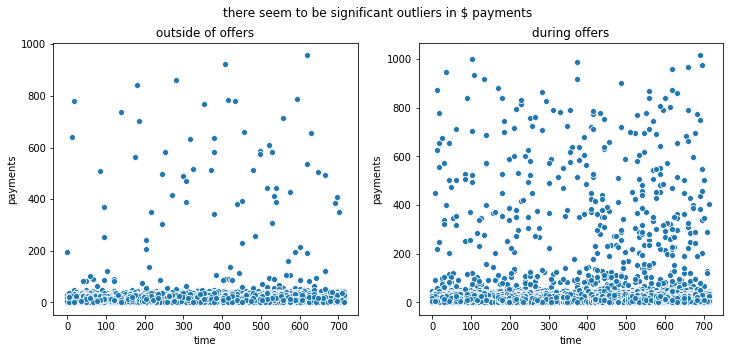

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(x="time",y="payments",data=transactions_outside_offer);
plt.title('outside of offers')

plt.subplot(122)
sns.scatterplot(x="time",y="payments",data=transactions_during_offer);
plt.title('during offers')

plt.suptitle('there seem to be significant outliers in $ payments');

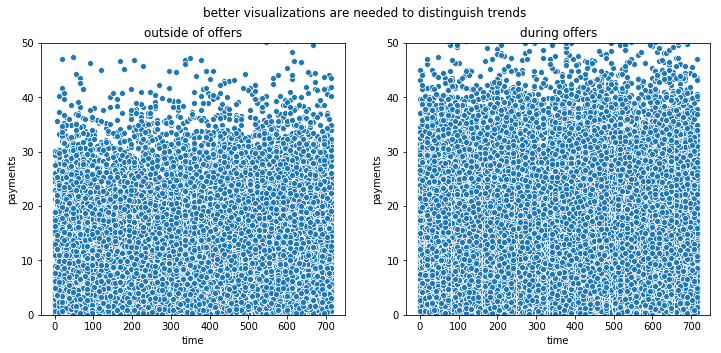

In [50]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(x="time",y="payments",data=transactions_outside_offer);
plt.title('outside of offers')
plt.ylim(0,50);

plt.subplot(122)
sns.scatterplot(x="time",y="payments",data=transactions_during_offer);
plt.title('during offers')
plt.ylim(0,50);

plt.suptitle("better visualizations are needed to distinguish trends");

In [15]:
offers_start_times=list(np.unique(out['offer_received'].dropna().values))
display(offers_start_times)



[0, 168, 336, 408, 504, 576]

[0, 168, 336, 408, 504, 576, 744]

In [16]:
transactions_outside_offer['day'] = pd.cut(transactions_outside_offer['time'],bins= np.arange(0,32)*24,labels=np.arange(0,31))
transactions_outside_offer['week'] = pd.cut(transactions_outside_offer['time'],bins= np.arange(0,5)*24*7,labels=np.arange(0,4))
transactions_outside_offer['start_time'] = pd.cut(transactions_outside_offer['time'],bins= offers_start_times+[745],labels=offers_start_times)


transactions_during_offer['day'] = pd.cut(transactions_during_offer['time'],bins= np.arange(0,32)*24,labels=np.arange(0,31))
transactions_during_offer['week'] = pd.cut(transactions_during_offer['time'],bins= np.arange(0,5)*24*7,labels=np.arange(0,4))
transactions_during_offer['start_time'] = pd.cut(transactions_during_offer['time'],bins= offers_start_times+[745],labels=offers_start_times)


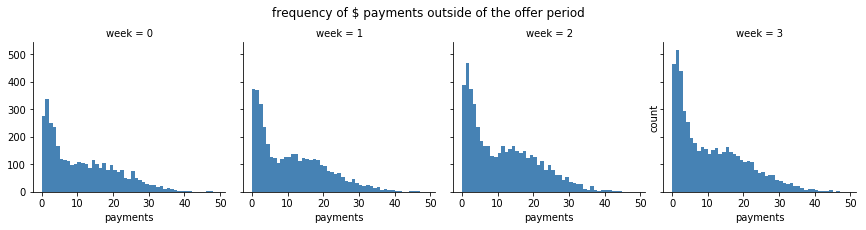

In [42]:
g = sns.FacetGrid(transactions_outside_offer, col="week",  margin_titles=True, col_wrap=5)
bins = range(0,50)
g.map(plt.hist, 'payments', color="steelblue", bins=bins)
plt.ylabel('count');
plt.suptitle('frequency of $ payments outside of the offer period',y=1.05,x=.4);

The distribution of payments outside of offers looks bimodal, suggesting that there could be two classes of customers.

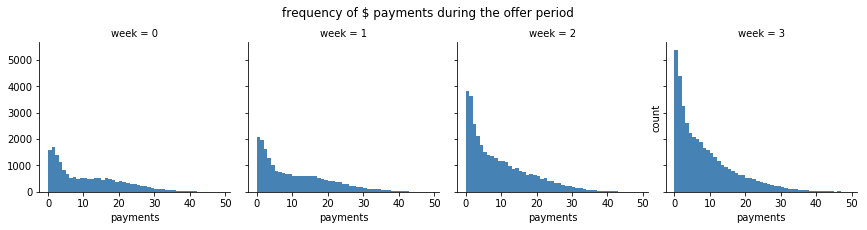

In [51]:
g = sns.FacetGrid(transactions_during_offer, col="week",  margin_titles=True, col_wrap=5)
bins = range(0,50)
g.map(plt.hist, 'payments', color="steelblue", bins=bins)
plt.ylabel('count');
plt.suptitle('frequency of $ payments during the offer period',y=1.05,x=.4);

The distribution of payments during offers:
* shows an increasing trend, but this could be an artifact due to different amount of offers in each week
* also apprears bimodal, at least in week 0 and week 1

We can repeat the analysis showing the behavior for the different offers and using time bins corresponding to each offer cycle.

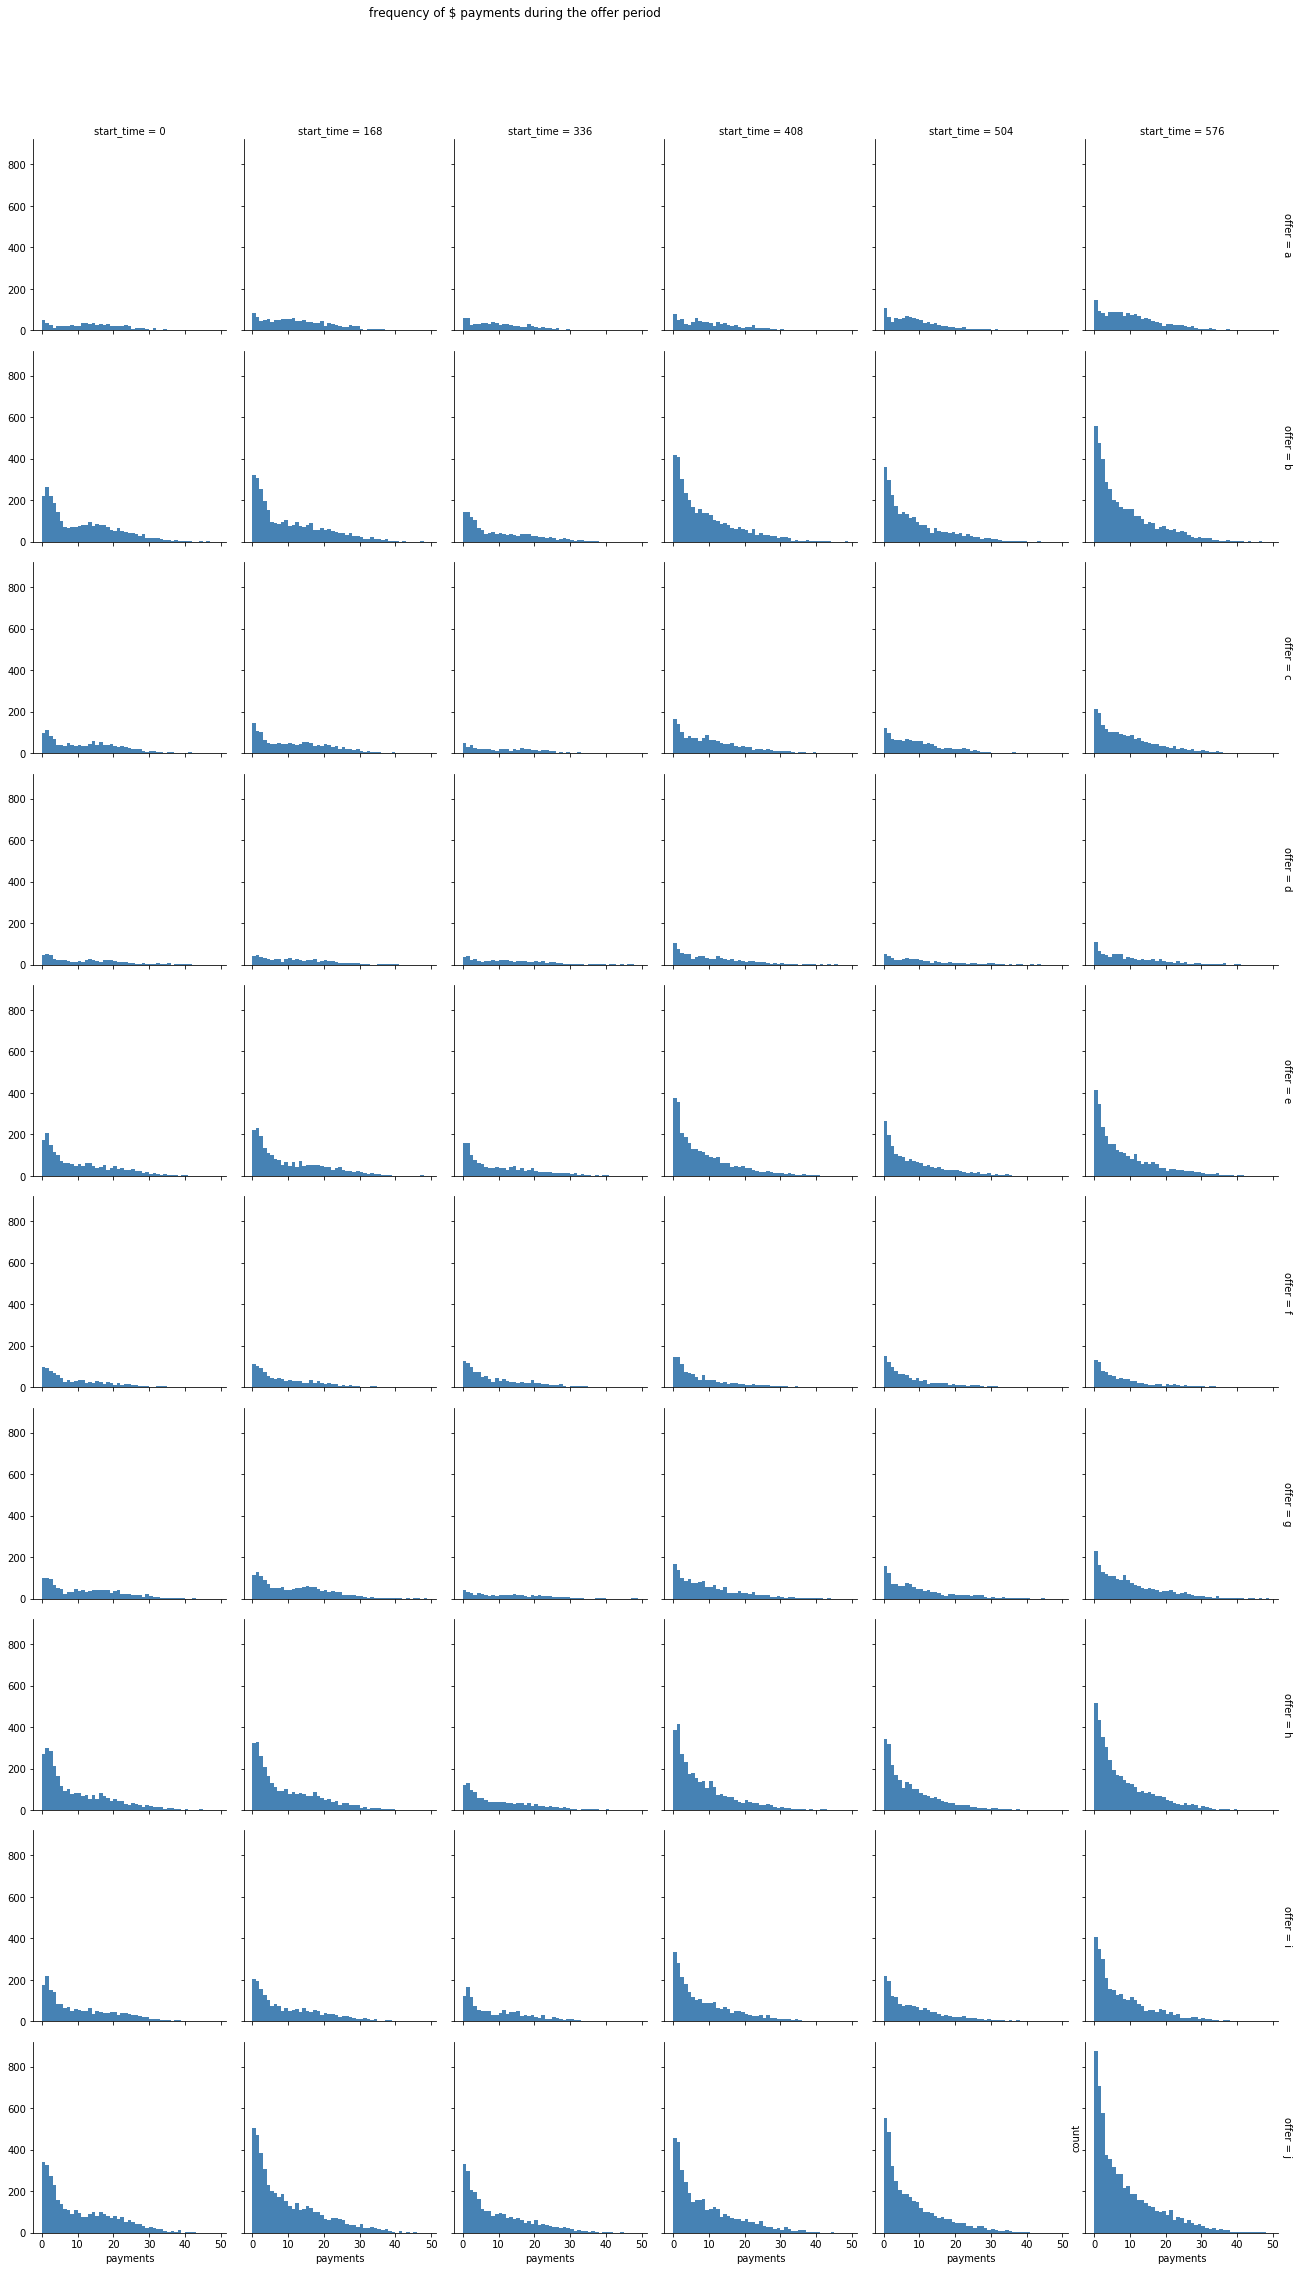

In [20]:
g = sns.FacetGrid(transactions_during_offer, col="start_time", row="offer", margin_titles=True, row_order=['a', 'b', 'c', 'd', 'e' ,'f', 'g', 'h', 'i', 'j'] )
bins = range(0,50)
g.map(plt.hist, 'payments', color="steelblue", bins=bins)
plt.ylabel('count');
plt.suptitle('frequency of $ payments during the offer period',y=1.05,x=.4);

In [21]:
# plt.figure(figsize=(10,5))
# sns.lineplot(x="days",y="payments",data=transactions_outside_offer,ci=95,label='')
# sns.lineplot(x="days",y="payments",data=transactions_during_offer,ci=95)

# # plt.ylim(0,50);
# plt.title('95% confidence interval')

## 3.1) Custom visualization

To visualize the trends in purchase, we produce a 2d data binning by time in days and by amount in set categories from 0.5 to 200$.
We visualize the bins as boxes whose color depends on the count of data points in the bin,
This is similiar to a [Spectrogram](https://en.wikipedia.org/wiki/Spectrogram), where the x axis is time, the y axis is frequency and the color is the intensity of the signal.

We add green bar to visualize the times at which the offer start.

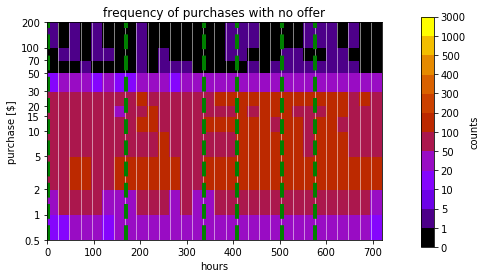

In [30]:
offers_start_times=np.unique(out['offer_received'].dropna().values)

xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000,3000])

fig,ax,ym,yM=bin_transactions(transactions_outside_offer,'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases with no offer');

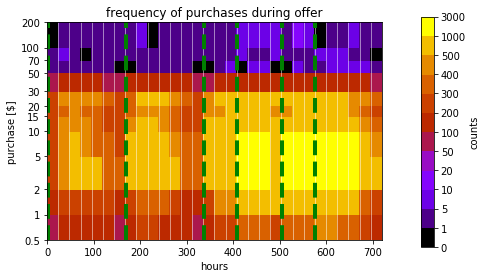

In [29]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000,3000])

fig,ax,ym,yM=bin_transactions(transactions_during_offer,'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer');

The binned plots show that the the number of purchases on average:
* increase significanlty in the offer period compared to outside the offers
* increase in for all dollar amounts but especially in the range between 2 and 10$
* increase rather quickly after an offer
* offers may have a cumulative effect: they don't seem to cancel each other 


In [61]:
profile_all['group118']=profile_all['age']>110
tdo=transactions_during_offer.merge(profile_all[['person','gender','age','income','group118']],on="person",how='left')
too=transactions_outside_offer.merge(profile_all[['person','gender','age','income','group118']],on="person",how='left')


### 3.1.1) Male customers

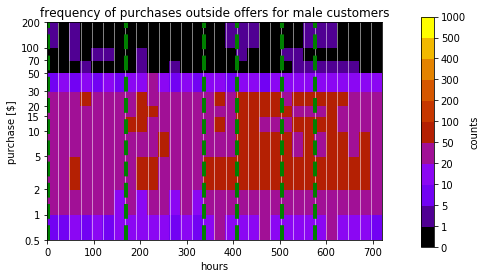

In [62]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])

fig,ax,ym,yM=bin_transactions(too.loc[tdo.gender=='M'],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases outside offers for male customers');

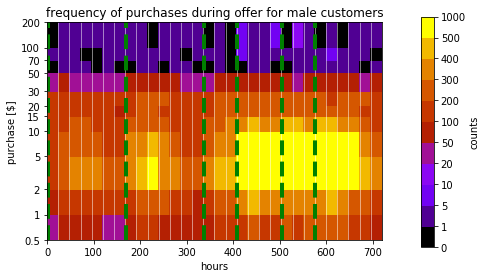

In [63]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])

fig,ax,ym,yM=bin_transactions(tdo.loc[tdo.gender=='M'],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer for male customers');

### 3.1.1) Female customers

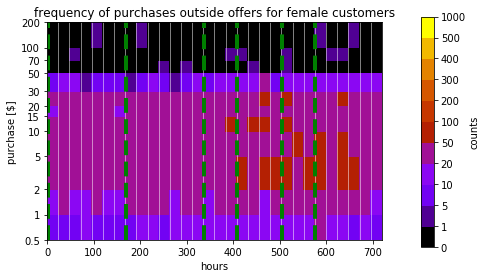

In [65]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])

fig,ax,ym,yM=bin_transactions(too.loc[tdo.gender=='F'],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases outside offers for female customers');

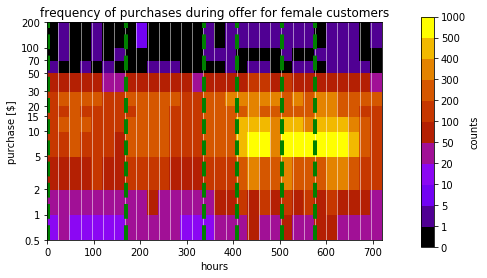

In [64]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])

fig,ax,ym,yM=bin_transactions(tdo.loc[tdo.gender=='F'],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer for female customers');

### 3.1.3) "Group 118": no information shared

In [70]:
profile_all['group118'].value_counts()

False    14825
True      2175
Name: group118, dtype: int64

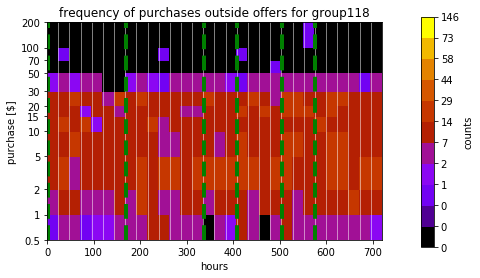

In [73]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])*2175/14825

fig,ax,ym,yM=bin_transactions(too.loc[tdo.group118==True],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases outside offers for group118');

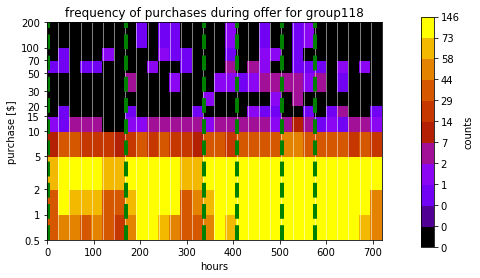

In [71]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])*2175/14825

fig,ax,ym,yM=bin_transactions(tdo.loc[tdo.group118==True],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer for group118');

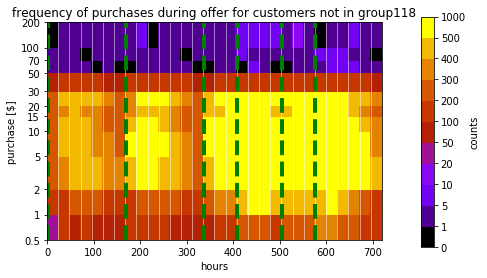

In [69]:
xedges=range(0,31*24,24)
yedges=np.array([0.5,1,2,5,10,15,20,30,50,70,100 ,200])
count_bins=np.array([0,1,5,10,20,50,100,200,300,400,500,1000 ])

fig,ax,ym,yM=bin_transactions(tdo.loc[tdo.group118==False],'time','payments',xedges,yedges,count_bins);
ax.vlines(xedges,ym,yM,lw=0.5,color='w',zorder=2);
ax.vlines(offers_start_times+1,ym,yM,lw=4,color='g',zorder=2,linestyle='--');

ax.set_title('frequency of purchases during offer for customers not in group118');

Once we correct the color scale to account for the different sizes of the groups we notice that customers in group118 tend to spend smaller amounts (0.5-5$) than other customers during offers.